<h1>Jamaica Stock Exchange Analysis  </h1>
<p> Basic anslysis data sciences information </p>
<ul> <li> Currently calculation using Simple Rate of Return </li>
<li> Adjustment of split stocks 2017-2018</li>
<li> Add Portfolio </li>
</ul>
<p><b> #Todo </b><i>Adjust for dividends to stock analysis</i></p>
<p><b> #Todo </b><i> Risk calculation </i></p>
<p><b> #Todo </b><i> Regression on stocks </i></p>
<p>&copy; 2018 Romayne Whyte (Ijasoft) <p>



In [1]:
import pandas as pd
import numpy as np
import os
import datetime 
import matplotlib.pyplot as plt
from scipy import linalg

<h2>Pulling Informtion from CSV Files</h2>

In [2]:
#Pull the valid stock information
slist = []
filelist = os.listdir('c:/project/stockcsv/')
for filename in filelist:
    slist.append(pd.read_csv('c:/project/stockcsv/'+filename))
    
frame = pd.concat(slist, axis = 0, ignore_index = True)
frame = frame.sort_values(by='Date')
frame.head()

,Symbol,Date,52 Week High,52 Week Low,Previous Year Div,Current Year Div,Volume (non block),Today High,Today Low,Last Traded,Close Price,Price Change,Closing Bid,Closing Ask
150104,NCBCM11.75,2008-01-02,NaN,NaN,NaN,NaN,100.0,3.00,3.00,3.00,3.00,0.00,2.86,3.00
150105,NCBJ,2008-01-02,43.05,15.55,NaN,NaN,1555011.0,23.00,22.80,23.00,23.00,0.05,22.95,23.04
150111,SVL,2008-01-02,5.00,1.60,NaN,NaN,32000.0,2.40,2.40,2.40,2.40,-0.43,2.38,2.40
150110,SLJ,2008-01-02,11.30,6.60,NaN,NaN,20189.0,8.15,8.00,8.00,8.00,0.00,8.00,8.15
150109,SGJ,2008-01-02,34.00,16.15,NaN,NaN,41066.0,21.05,21.05,21.05,21.05,-0.25,21.05,21.45


In [3]:
#Pull the list of delisted to remove from stock frame
framevalid = pd.read_csv('c:/project/stockdelist/stockvalid.csv')
framevalid = framevalid.rename(columns={'Instrument Code': 'Symbol'})
framevalid.head()

,Name,Symbol,Currency,Sector,Type,Website
0,138 STUDENT LIVING JAMAICA LIMITED,138SL,JMD,OTHER,ORDINARY,-
1,138 STUDENT LIVING JAMAICA LIMITED VARIABLE PR...,138SLVR,JMD,OTHER,PREFERENCE,-
2,1834 INVESTMENTS LIMITED,1834,JMD,COMMUNICATIONS,ORDINARY,Website
3,BARITA INVESTMENTS LIMITED,BIL,JMD,FINANCE,ORDINARY,Website
4,BERGER PAINTS JAMAICA LTD.,BRG,JMD,MANUFACTURING,ORDINARY,Website


In [4]:
slist = []
slist.append(pd.read_csv('c:/project/stocksplit/corporate-actions (1).csv'))
slist.append(pd.read_csv('c:/project/stocksplit/corporate-actions (2).csv'))
df_info = pd.concat(slist, axis = 0, ignore_index = True)
df_info.head()

,Symbol,Record Date,Action,Dividend Amount,Ex-Date,Payment Date
0,EPLY,12/4/2018,NaN,0.037200,12/3/2018,12/18/2018
1,1834,12/3/2018,NaN,0.100000,11/30/2018,12/19/2018
2,JMMBGL7.50,11/30/2018,NaN,0.004635,11/29/2018,12/14/2018
3,JMMBGL7.25,11/30/2018,NaN,0.006953,11/29/2018,12/14/2018
4,SIL,11/27/2018,Stock Split,5.000000,11/26/2018,NaN


In [5]:
#Pull the valid stock Indicies

slist = []
filelist = os.listdir('c:/project/stockindicies/')
for filename in filelist:
    slist.append(pd.read_csv('c:/project/stockindicies/'+filename))
    
stkindices_frame = pd.concat(slist, axis = 0, ignore_index = True)
stkindices_frame = stkindices_frame.dropna(axis=0)
stkindices_frame.head()

,Index,Date,Value,Change ($),Change (%),Volume Traded
0,Combined-Index,2017-01-03,206552.15,1592.05,0.78,7228125.0
1,JSE-Index,2017-01-03,194129.75,1853.11,0.96,6933316.0
2,All-Jamaican,2017-01-03,212211.90,2072.41,0.99,6555316.0
3,JSE-Select,2017-01-03,6493.43,89.66,1.40,4924157.0
5,JSE-Junior,2017-01-03,2581.42,-12.29,-0.47,294809.0


<h2>Time for Clean Up</h2>

In [6]:
stkindices_frame = stkindices_frame.drop(['Change ($)','Change (%)','Volume Traded'],axis=1)
stkindices_frame['Date'] = pd.to_datetime(stkindices_frame['Date'])

In [7]:
#split the indicies by index
gp_index = stkindices_frame.groupby("Index")
stk_indicies_list = [gp_index.get_group(x) for x in gp_index.groups]

df_ind_data = pd.DataFrame()
for idx, index in enumerate(stk_indicies_list):
    stk_indicies_list[idx] = stk_indicies_list[idx].set_index('Date')
    df_ind_data[index['Index'].iloc[0]] = stk_indicies_list[idx]['Value']

df_ind_data.head()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2017-01-03,212211.90,206552.15,NaN,194129.75,2581.42,6493.43,164.50
2017-01-04,212416.50,206763.30,NaN,194312.69,2585.46,6504.28,164.75
2017-01-05,210401.76,205435.54,NaN,192511.16,2618.81,6442.53,164.82
2017-01-06,213648.57,208184.36,NaN,195414.38,2624.32,6531.55,162.90
2017-01-09,213231.99,208674.85,NaN,195041.89,2705.63,6536.54,164.69


In [8]:
frame = frame.rename(columns={'Close Price': 'Close'})
frame.head()

,Symbol,Date,52 Week High,52 Week Low,Previous Year Div,Current Year Div,Volume (non block),Today High,Today Low,Last Traded,Close,Price Change,Closing Bid,Closing Ask
150104,NCBCM11.75,2008-01-02,NaN,NaN,NaN,NaN,100.0,3.00,3.00,3.00,3.00,0.00,2.86,3.00
150105,NCBJ,2008-01-02,43.05,15.55,NaN,NaN,1555011.0,23.00,22.80,23.00,23.00,0.05,22.95,23.04
150111,SVL,2008-01-02,5.00,1.60,NaN,NaN,32000.0,2.40,2.40,2.40,2.40,-0.43,2.38,2.40
150110,SLJ,2008-01-02,11.30,6.60,NaN,NaN,20189.0,8.15,8.00,8.00,8.00,0.00,8.00,8.15
150109,SGJ,2008-01-02,34.00,16.15,NaN,NaN,41066.0,21.05,21.05,21.05,21.05,-0.25,21.05,21.45


In [9]:
framevalid = framevalid[framevalid.Type == "ORDINARY"]
framevalid.head()

,Name,Symbol,Currency,Sector,Type,Website
0,138 STUDENT LIVING JAMAICA LIMITED,138SL,JMD,OTHER,ORDINARY,-
2,1834 INVESTMENTS LIMITED,1834,JMD,COMMUNICATIONS,ORDINARY,Website
3,BARITA INVESTMENTS LIMITED,BIL,JMD,FINANCE,ORDINARY,Website
4,BERGER PAINTS JAMAICA LTD.,BRG,JMD,MANUFACTURING,ORDINARY,Website
6,CARIBBEAN CEMENT COMPANY LTD.,CCC,JMD,MANUFACTURING,ORDINARY,Website


In [10]:
#Remove unnecessary columns
frame = frame.drop(['52 Week High','52 Week Low','Current Year Div','Today High','Today Low','Last Traded','Price Change','Closing Bid','Closing Ask','Previous Year Div','Volume (non block)'],axis=1)
frame.head()

,Symbol,Date,Close
150104,NCBCM11.75,2008-01-02,3.00
150105,NCBJ,2008-01-02,23.00
150111,SVL,2008-01-02,2.40
150110,SLJ,2008-01-02,8.00
150109,SGJ,2008-01-02,21.05


In [11]:
#filter for only the valid stocks
frame = frame[frame["Symbol"].isin(framevalid["Symbol"].tolist())]
frame.head()

,Symbol,Date,Close
150111,SVL,2008-01-02,2.40
150109,SGJ,2008-01-02,21.05
150108,RJR,2008-01-02,3.27
150107,PJAM,2008-01-02,47.00
150103,MIL,2008-01-02,4.50


In [12]:

frame['Date'] = pd.to_datetime(frame['Date'])
frame.head()

,Symbol,Date,Close
150111,SVL,2008-01-02,2.40
150109,SGJ,2008-01-02,21.05
150108,RJR,2008-01-02,3.27
150107,PJAM,2008-01-02,47.00
150103,MIL,2008-01-02,4.50


In [13]:
#Extract the Split Information from the Info dataframe
df_info["Action"] = df_info["Action"].str.strip()
df_split = df_info[df_info["Action"]=='Stock Split']
df_split = df_split.drop(['Record Date','Action','Payment Date'],axis=1)
df_split['Ex-Date'] = pd.to_datetime(df_split['Ex-Date'])
df_split = df_split.dropna(axis=0,how='any')
df_split

,Symbol,Dividend Amount,Ex-Date
4,SIL,5.0,2018-11-26
57,DTL,10.0,2018-09-05
65,BPOW,10.0,2018-08-28
269,CAR,10.0,2017-09-18
323,PULS,5.0,2017-07-03
336,JETCON,4.0,2017-06-22
355,KEX,5.0,2017-05-31
362,KPREIT,2.0,2017-05-19
384,JAMT,2.0,2017-04-18
409,AMG,5.0,2017-03-10


In [14]:
#Extract the Dividend from the Info Dataframe
df_info["Action"] = df_info["Action"].str.strip()
df_div = df_info[df_info["Action"]!='Stock Split']
df_div = df_info.drop(['Action','Record Date','Payment Date'],axis=1)
df_div['Ex-Date'] = pd.to_datetime(df_div['Ex-Date'])
df_div = df_div.dropna(axis=0,how='any')

In [15]:
df_div.head()

,Symbol,Dividend Amount,Ex-Date
0,EPLY,0.037200,2018-12-03
1,1834,0.100000,2018-11-30
2,JMMBGL7.50,0.004635,2018-11-29
3,JMMBGL7.25,0.006953,2018-11-29
4,SIL,5.000000,2018-11-26


In [16]:
df_div.tail()

,Symbol,Dividend Amount,Ex-Date
441,JMMB7.5,0.0127,2017-01-18
442,JMMB7.25,0.0154,2017-01-18
443,PAL,1.0000,2017-01-05
444,HONBUN,0.0200,2017-01-05
445,PJAM,0.2000,2017-01-04


In [17]:
#Fix the stock Split Issues
frame['split'] = 1.0#np.nan
frame['dividend'] = 0.00 #np.nan
frame.head()

,Symbol,Date,Close,split,dividend
150111,SVL,2008-01-02,2.40,1.0,0.0
150109,SGJ,2008-01-02,21.05,1.0,0.0
150108,RJR,2008-01-02,3.27,1.0,0.0
150107,PJAM,2008-01-02,47.00,1.0,0.0
150103,MIL,2008-01-02,4.50,1.0,0.0


In [18]:
#Remove Duplicated stock price
frame = frame.drop_duplicates(subset = ["Symbol","Date"], keep=False)

In [19]:
#Can be used to check for duplication but will raise error of no duplication 
#pd.concat(g for _, g in frame.groupby(["Symbol","Date"]) if len(g) > 1)

In [20]:
gp = frame.groupby("Symbol")

In [21]:
stklist = [gp.get_group(x) for x in gp.groups]

# swap CAR with 138SL
temp = stklist[0]
stklist[0] = stklist[10]
stklist[10] = temp

In [22]:
for idx, stk in enumerate(stklist):
    stklist[idx] = stklist[idx].set_index('Date')

stklist[0].head()

,Symbol,Close,split,dividend
Date,,,,
2008-01-02,CCC,9.50,1.0,0.0
2008-01-03,CCC,10.00,1.0,0.0
2008-01-04,CCC,10.00,1.0,0.0
2008-01-07,CCC,10.00,1.0,0.0
2008-01-08,CCC,10.45,1.0,0.0


In [23]:
#Assign the split values per symbol and date from split dataframe to the stock dataframe
for idx, stk in enumerate(stklist):    
    symbol = stk['Symbol'][0]
    if not df_split[(df_split.Symbol == symbol)].empty:
        split_s = df_split[(df_split.Symbol == symbol)]        
        stk.at[split_s['Ex-Date'].iloc[0],'split'] = split_s['Dividend Amount'].iloc[0]
        print(stk[stk.index.isin(split_s['Ex-Date'].tolist())])
        stklist[idx] = stk                

           Symbol  Close  split  dividend
Date                                     
2017-03-10    AMG   4.87    5.0       0.0
           Symbol  Close  split  dividend
Date                                     
2018-08-28   BPOW    4.7   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-09-18    CAR  10.87   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2018-09-05    DTL   2.65   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-04-18   JAMT   3.67    2.0       0.0
            Symbol  Close  split  dividend
Date                                      
2017-06-22  JETCON   5.66    4.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-05-31    KEX   15.0    5.0       0.0
            Symbol  Close  split  dividend
Date                                      
2017-05-19  KPREIT    8.3    

In [24]:
#Assign the dividend values per symbol and date from info dataframe to the stock dataframe
for idx, stk in enumerate(stklist):    
    symbol = stk['Symbol'][0]
    if not df_div[(df_div.Symbol == symbol)].empty:
        div_s = df_div[(df_div.Symbol == symbol)]
        for ds in div_s.values:            
            stk.at[ds[2],'dividend'] = ds[1]        
        
        stklist[idx] = stk  

stklist[0].head()

,Symbol,Close,split,dividend
Date,,,,
2008-01-02,CCC,9.50,1.0,0.0
2008-01-03,CCC,10.00,1.0,0.0
2008-01-04,CCC,10.00,1.0,0.0
2008-01-07,CCC,10.00,1.0,0.0
2008-01-08,CCC,10.45,1.0,0.0


In [25]:
# https://joshschertz.com/2016/08/27/Vectorizing-Adjusted-Close-with-Python/
def calculate_adjusted_prices(df, column):
    """ Vectorized approach for calculating the adjusted prices for the
    specified column in the provided DataFrame. This creates a new column
    called 'adj_<column name>' with the adjusted prices. This function requires
    that the DataFrame have columns with dividend and split_ratio values.

    :param df: DataFrame with raw prices along with dividend and split_ratio
        values
    :param column: String of which price column should have adjusted prices
        created for it
    :return: DataFrame with the addition of the adjusted price column
    """
    adj_column = 'adj_' + column + '_Check'

    # Reverse the DataFrame order, sorting by date in descending order
    df.sort_index(ascending=False, inplace=True)

    price_col = df[column].values
    split_col = df['split'].values
    dividend_col = df['dividend'].values
    adj_price_col = np.zeros(len(df.index))
    adj_price_col[0] = price_col[0]
          
    for i in range(1, len(price_col)):
        adj_price_col[i] = round((adj_price_col[i - 1] + adj_price_col[i - 1] *
                   (((price_col[i] * (1/split_col[i - 1])) -
                     price_col[i - 1]) / price_col[i - 1])), 4)

    df[adj_column] = adj_price_col

    # Change the DataFrame order back to dates ascending
    df.sort_index(ascending=True, inplace=True)

    return df

In [26]:
for idx, stk in enumerate(stklist):        
    stklist[idx] = calculate_adjusted_prices(stklist[idx],'Close')

stklist[0].head()

,Symbol,Close,split,dividend,adj_Close_Check
Date,,,,,
2008-01-02,CCC,9.50,1.0,0.0,9.50
2008-01-03,CCC,10.00,1.0,0.0,10.00
2008-01-04,CCC,10.00,1.0,0.0,10.00
2008-01-07,CCC,10.00,1.0,0.0,10.00
2008-01-08,CCC,10.45,1.0,0.0,10.45


In [27]:
stkframe = pd.DataFrame()
for stk in stklist:
    stkframe[stk['Symbol'][0]] = stk['adj_Close_Check']

In [28]:
stkframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.40,NaN,NaN,NaN,NaN
2008-01-03,10.00,4.19,NaN,NaN,NaN,NaN,NaN,NaN,7.101,NaN,...,NaN,NaN,NaN,NaN,NaN,2.75,NaN,NaN,NaN,NaN
2008-01-04,10.00,4.05,NaN,NaN,NaN,NaN,3.02,NaN,7.800,0.01,...,NaN,NaN,NaN,NaN,NaN,2.75,NaN,NaN,NaN,NaN
2008-01-07,10.00,4.00,NaN,NaN,NaN,NaN,3.05,NaN,7.799,NaN,...,NaN,NaN,NaN,NaN,NaN,2.51,NaN,NaN,NaN,NaN
2008-01-08,10.45,4.00,NaN,NaN,NaN,NaN,3.05,NaN,7.400,NaN,...,NaN,NaN,NaN,NaN,NaN,2.80,NaN,NaN,NaN,NaN


In [29]:
stkframe.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,43.79,1.16,50.5,1.83,29.49,5.45,18.00,16.9,9.36,0.14,...,49.52,4.99,8.20,3.5,1.74,16.95,5.19,3.61,10.59,11.85
2018-12-04,42.41,1.17,50.5,1.83,28.23,5.45,18.50,16.9,9.08,0.14,...,49.05,4.81,7.58,3.5,1.80,16.91,5.19,3.65,10.50,11.28
2018-12-05,49.15,1.17,50.5,1.65,31.33,5.45,18.50,16.9,9.17,0.14,...,48.62,4.81,8.54,3.5,1.79,16.56,5.19,3.91,10.50,11.24
2018-12-06,43.62,1.16,50.5,1.70,33.00,5.45,18.75,16.9,9.05,0.14,...,44.77,5.20,8.95,3.5,1.81,16.41,5.19,3.74,10.41,11.20
2018-12-07,44.27,1.16,50.5,1.70,32.42,5.45,18.49,16.9,9.13,0.14,...,40.33,5.20,8.59,3.5,1.81,16.28,5.19,3.66,10.27,11.05


In [30]:
divframe = pd.DataFrame()
for div in stklist:
    divframe[div['Symbol'][0]] = div['dividend']

In [31]:
divframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-04,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-07,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-08,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [32]:
divframe[divframe['SCIJMD'] > 0]['SCIJMD']

Series([], Name: SCIJMD, dtype: float64)

In [33]:
#filter the data for the 01 January 2018 to 31 December, 2018

startdate = '2017-01-01'
enddate = '2018-12-31'

stkframe=stkframe[startdate:enddate]
divframe = divframe[startdate:enddate]
df_ind_data = df_ind_data[startdate:enddate]

In [34]:
stkframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 486 entries, 2017-01-03 to 2018-12-07
Data columns (total 73 columns):
CCC         486 non-null float64
1834        486 non-null float64
AFS         486 non-null float64
AMG         486 non-null float64
BIL         486 non-null float64
BPOW        486 non-null float64
BRG         486 non-null float64
CAC         486 non-null float64
CAR         486 non-null float64
CBNY        486 non-null float64
138SL       486 non-null float64
CFF         486 non-null float64
CHL         486 non-null float64
CPJ         486 non-null float64
DCOVE       486 non-null float64
DTL         486 non-null float64
ECL         348 non-null float64
EFRESH      118 non-null float64
ELITE       203 non-null float64
EPLY        486 non-null float64
FOSRICH     242 non-null float64
GENAC       486 non-null float64
GK          486 non-null float64
GWEST       242 non-null float64
HONBUN      486 non-null float64
INDIES      82 non-null float64
ISP         486 non

In [35]:
stkframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,33.85,1.22,22.0,4.902,6.00,2.900,5.80,5.09,6.620,0.18,...,29.04,NaN,NaN,3.86,NaN,5.31,5.3,NaN,NaN,11.58
2017-01-04,34.25,1.24,22.0,4.902,6.50,2.900,5.80,5.09,6.608,0.16,...,29.86,NaN,NaN,3.86,NaN,5.11,5.3,NaN,NaN,10.49
2017-01-05,33.36,1.22,22.0,5.402,6.17,2.900,5.80,5.09,6.636,0.16,...,28.28,NaN,NaN,3.86,NaN,5.11,5.3,NaN,NaN,10.41
2017-01-06,33.50,1.23,22.0,5.402,6.17,3.100,5.78,5.09,6.659,0.20,...,29.03,NaN,NaN,3.86,NaN,5.21,5.3,NaN,NaN,10.48
2017-01-09,31.46,1.21,25.0,5.700,6.17,3.429,6.00,5.25,6.644,0.20,...,29.02,NaN,NaN,3.86,NaN,5.10,5.3,NaN,NaN,10.21


In [36]:
stkframe.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-03,43.79,1.16,50.5,1.83,29.49,5.45,18.00,16.9,9.36,0.14,...,49.52,4.99,8.20,3.5,1.74,16.95,5.19,3.61,10.59,11.85
2018-12-04,42.41,1.17,50.5,1.83,28.23,5.45,18.50,16.9,9.08,0.14,...,49.05,4.81,7.58,3.5,1.80,16.91,5.19,3.65,10.50,11.28
2018-12-05,49.15,1.17,50.5,1.65,31.33,5.45,18.50,16.9,9.17,0.14,...,48.62,4.81,8.54,3.5,1.79,16.56,5.19,3.91,10.50,11.24
2018-12-06,43.62,1.16,50.5,1.70,33.00,5.45,18.75,16.9,9.05,0.14,...,44.77,5.20,8.95,3.5,1.81,16.41,5.19,3.74,10.41,11.20
2018-12-07,44.27,1.16,50.5,1.70,32.42,5.45,18.49,16.9,9.13,0.14,...,40.33,5.20,8.59,3.5,1.81,16.28,5.19,3.66,10.27,11.05


In [37]:
#filter the data for the 01 January 2018 to 03 December, 2018
#df_ind_data=df_ind_data['2018-01-01': '2018-11-31']

df_ind_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 487 entries, 2017-01-03 to 2018-12-07
Data columns (total 7 columns):
All-Jamaican      487 non-null float64
Combined-Index    487 non-null float64
Cross-Listed      30 non-null float64
JSE-Index         487 non-null float64
JSE-Junior        487 non-null float64
JSE-Select        487 non-null float64
US-Equities       485 non-null float64
dtypes: float64(7)
memory usage: 30.4 KB


<h2>Time for Some Financial Analysis</h2>

<h3> Analysis for the indicies <h3>

In [113]:
#Jamica Indices Return 
ind_returns = np.log(df_ind_data / df_ind_data.shift(1)) 
ind_returns.head()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.000964,0.001022,NaN,0.000942,0.001564,0.001670,0.001519
2017-01-05,-0.009530,-0.006442,NaN,-0.009315,0.012817,-0.009539,0.000425
2017-01-06,0.015314,0.013292,NaN,0.014968,0.002102,0.013723,-0.011717
2017-01-09,-0.001952,0.002353,NaN,-0.001908,0.030513,0.000764,0.010928


In [39]:
ind_returns.tail()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2018-12-03,0.005592,0.004955,NaN,0.005592,-0.001603,0.010515,0.005188
2018-12-04,0.000270,0.000794,NaN,0.000270,0.006229,-0.007344,-0.013646
2018-12-05,0.000118,-0.000758,NaN,0.000118,-0.009778,-0.007766,0.006677
2018-12-06,-0.025393,-0.023098,NaN,-0.025393,0.000777,-0.034573,-0.005915
2018-12-07,-0.022632,-0.020291,NaN,-0.022632,0.003421,-0.030327,0.029753


<Figure size 2880x1440 with 0 Axes>

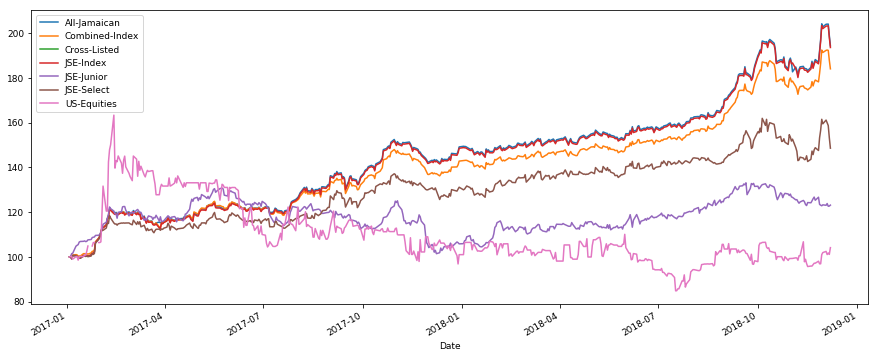

In [114]:
#ind_returns['All-Jamaican'].plot()
plt.figure(figsize=(40,20))
plt.rcParams.update({'font.size': 9})
#plt.show()
(df_ind_data / df_ind_data.iloc[0] * 100).plot(figsize=(15, 6));
plt.show()


In [115]:
#indicies Annual Rate of Return
annual_ind_returns = ind_returns.apply(lambda x: (x.mean()*250) if  x.count() > 250 else (x.mean() * x.count())) 
#annual_ind_returns = ind_returns.mean() * ind_returns.count()
annual_ind_returns

All-Jamaican      0.341888
Combined-Index    0.313815
Cross-Listed     -0.048789
JSE-Index         0.339816
JSE-Junior        0.107122
JSE-Select        0.203731
US-Equities       0.021070
dtype: float64

<h3> Analysis for Jamaia Stocks </h3>

In [112]:
# This is rate of returns with dividends involved
#rate_return = ((stkframe+divframe)/stkframe.shift(1))-1

# This is rate of returns without dividends involved
rate_return = np.log(stkframe/stkframe.shift(1))

rate_return['VMIL'].mean() * 237


#rate_return.head()

0.12188981760903714

In [116]:
rate_return = rate_return.replace([np.inf, -np.inf], np.nan)
rate_return.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.011748,0.016261,0.000000,0.000000,0.080043,0.000000,0.000000,0.00000,-0.001814,-0.117783,...,0.027846,NaN,NaN,0.0,NaN,-0.038392,0.0,NaN,NaN,-0.098857
2017-01-05,-0.026329,-0.016261,0.000000,0.097126,-0.052103,0.000000,0.000000,0.00000,0.004228,0.000000,...,-0.054365,NaN,NaN,0.0,NaN,0.000000,0.0,NaN,NaN,-0.007656
2017-01-06,0.004188,0.008163,0.000000,0.000000,0.000000,0.066691,-0.003454,0.00000,0.003460,0.223144,...,0.026175,NaN,NaN,0.0,NaN,0.019380,0.0,NaN,NaN,0.006702
2017-01-09,-0.062829,-0.016394,0.127833,0.053697,0.000000,0.100867,0.037356,0.03095,-0.002255,0.000000,...,-0.000345,NaN,NaN,0.0,NaN,-0.021339,0.0,NaN,NaN,-0.026101


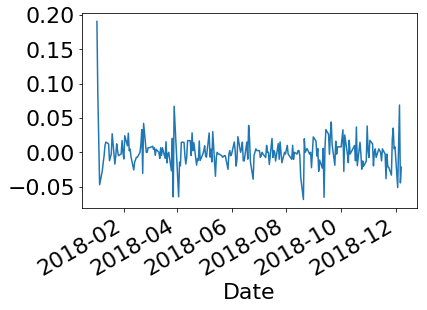

<Figure size 2400x1200 with 0 Axes>

In [135]:
#Sample of rate of return
rate_return['VMIL'].plot()
plt.figure(figsize=(30,15), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 10})
plt.show()

[]

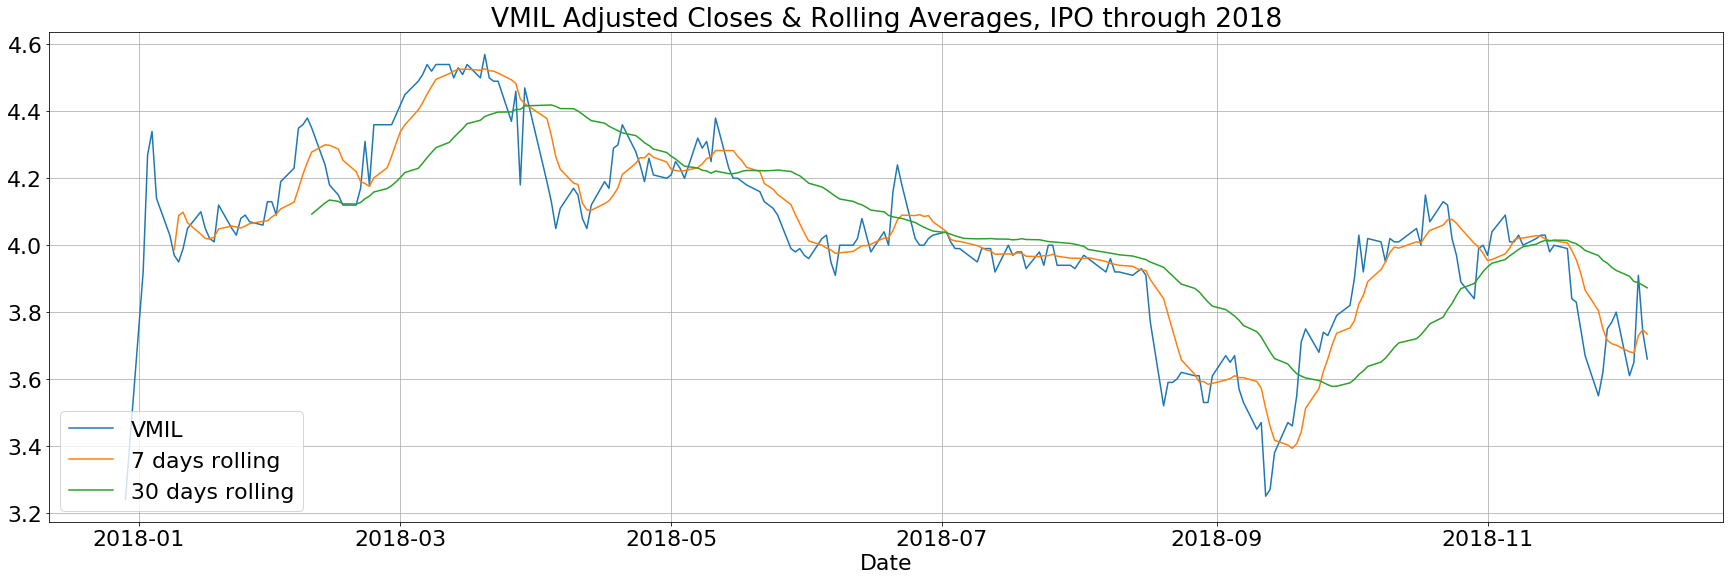

In [134]:

sym = 'VMIL'

df_closing = stkframe[sym]
df_7days = df_closing.rolling( 7 ).mean()
df_30days = df_closing.rolling( 30 ).mean()

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
fig.autofmt_xdate()
ax = fig.add_subplot(1,1,1)
ax.plot(df_closing.index, df_closing, label=sym)
ax.plot(df_7days.index, df_7days, label='7 days rolling')
ax.plot(df_30days.index, df_30days, label='30 days rolling')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('Date')
plt.title(sym+' Adjusted Closes & Rolling Averages, IPO through 2018')
plt.plot()

In [119]:
stkframe['PULS'].dropna().head()

Date
2017-01-03    0.712
2017-01-04    0.800
2017-01-05    0.796
2017-01-06    0.764
2017-01-09    0.794
Name: PULS, dtype: float64

In [120]:
stkframe['PULS'].tail()

Date
2018-12-03    3.60
2018-12-04    3.24
2018-12-05    3.20
2018-12-06    3.20
2018-12-07    3.20
Name: PULS, dtype: float64

In [121]:

#Calculate the Average Rate of Return

avg_returns = rate_return.apply(lambda x: (x.mean()*250) if  x.count() > 250 else (x.mean() * x.count()))

# Drop all records with no application
avg_returns = avg_returns.dropna()
# Drop all record with 0 as rate of return
avg_returns = avg_returns.drop(avg_returns[avg_returns == 0].index)
round(avg_returns[avg_returns > 0].sort_values(),5)*100

DCOVE         2.515
SSLVC         3.371
WISYNCO       3.669
SEP           4.456
MJE           4.632
KPREIT        9.398
GENAC        11.260
LASF         11.470
VMIL         12.189
CCC          13.833
CAR          16.571
SJ           16.929
FOSRICH      18.009
SIL          18.435
ProvenJA     18.524
GK           19.128
SGJ          19.777
MDS          22.193
KLE          22.205
CFF          23.687
JSE          24.628
CPJ          25.671
KEY          27.244
JAMT         29.688
EPLY         31.340
BPOW         32.521
MIL          32.574
ELITE        36.116
JBG          37.254
JMMBGL       40.822
JETCON       41.877
AFS          42.831
ISP          44.107
PJAM         45.988
JP           49.253
NCBFG        50.465
KEX          54.461
SVL          57.750
BRG          59.761
CAC          61.858
KW           63.177
MEEG         64.057
SALF         65.007
INDIES       72.594
PULS         77.465
DTL          82.018
BIL          86.960
MUSIC        97.898
PAL         103.419
ECL         107.157


In [122]:
#find the stocks that have split
round(avg_returns[avg_returns <= 0].sort_values(),5)*100

GWEST    -64.885
AMG      -54.588
EFRESH   -49.698
SCIJMD   -45.988
LASD     -32.458
RJR      -21.107
HONBUN   -20.719
PJX      -19.366
SCIJA    -18.349
LASM     -17.557
138SL    -13.183
CBNY     -12.954
KREMI    -11.571
CHL      -10.845
SML       -5.609
SRA       -5.047
ROC       -4.019
1834      -2.600
PURITY    -2.572
XFUND     -2.415
TTECH     -1.081
PTL       -0.863
dtype: float64

<h2> Calculate Stock Risk </h2>

In [123]:
stk_std_risk = rate_return.apply(lambda x: (x.std()* 250 ** 0.5 ) if  x.count() > 250 else (x.mean() * x.count() ** 0.5))
round(stk_std_risk[stk_std_risk > 0].sort_values(),5) * 100

WISYNCO       0.238
SSLVC         0.395
MJE           0.488
VMIL          0.792
FOSRICH       1.160
ELITE         2.541
INDIES        8.066
SRA          15.179
ProvenJA     20.037
GK           25.271
NCBFG        27.357
138SL        33.046
CAR          34.133
SJ           34.936
CHL          39.205
PJAM         40.539
SGJ          42.979
JBG          45.379
ROC          47.137
JMMBGL       47.946
KW           49.869
XFUND        49.919
PJX          51.137
DCOVE        53.140
KPREIT       53.891
LASM         54.281
LASD         54.620
AFS          55.245
KEX          56.249
SVL          56.379
             ...   
ISP          61.701
CPJ          62.676
RJR          63.258
GENAC        63.431
LASF         64.044
JSE          65.227
1834         65.460
JAMT         65.567
BRG          68.716
SALF         71.098
TTECH        71.182
SIL          71.581
HONBUN       71.693
EPLY         73.927
MDS          76.395
KLE          76.748
PTL          76.825
BPOW         76.911
KEY          77.293


In [124]:
round(stk_std_risk[stk_std_risk < 0].sort_values(),5) * 100

EFRESH   -4.595
SCIJMD   -4.181
GWEST    -4.180
SCIJA    -1.668
SML      -0.643
dtype: float64

<h2> Portfolio Assessment </h2>

In [125]:
value = stkframe.count(axis=0)
value = value.index[stkframe.count(axis=0) == stkframe['CAR'].count()]
value

Index(['CCC', '1834', 'AFS', 'AMG', 'BIL', 'BPOW', 'BRG', 'CAC', 'CAR', 'CBNY',
       '138SL', 'CFF', 'CHL', 'CPJ', 'DCOVE', 'DTL', 'EPLY', 'GENAC', 'GK',
       'HONBUN', 'ISP', 'JAMT', 'JBG', 'JETCON', 'JMMBGL', 'JP', 'JSE', 'KEX',
       'KEY', 'KLE', 'KPREIT', 'KREMI', 'KW', 'LASD', 'LASF', 'LASM', 'MDS',
       'MIL', 'PAL', 'PJAM', 'PJX', 'PTL', 'PULS', 'PURITY', 'ProvenJA', 'RJR',
       'ROC', 'SALF', 'SEP', 'SGJ', 'SIL', 'SJ', 'SRA', 'SVL', 'TTECH',
       'XFUND'],
      dtype='object')

In [126]:
#Porfolio
selectStock = []
for i in range(0,6):
    rand_indx = np.random.randint(len(value))
    selectStock.append(value[rand_indx])

selectStock

['JSE', 'CHL', 'MIL', 'EPLY', 'BIL', 'TTECH']

C:\Users\Romayne\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


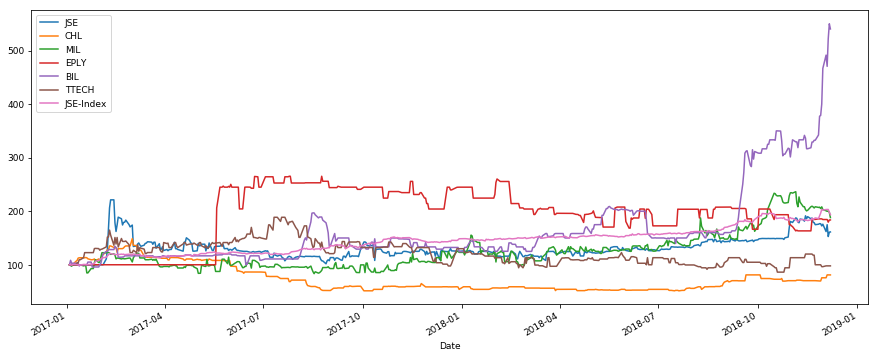

In [129]:
portfolio_compare = pd.DataFrame
portfolio_compare = stkframe[selectStock]
portfolio_compare['JSE-Index'] = df_ind_data['JSE-Index']
(portfolio_compare / portfolio_compare.iloc[0] * 100).plot(figsize = (15, 6));
plt.rcParams.update({'font.size': 9})
plt.show()
#df_ind_data['JSE-Index']
#portfolio_compare[selectStock].tail()

In [128]:
weights = np.array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [130]:
portfolio = str(round(np.dot(avg_returns[selectStock], weights),5) * 100) + "%"
portfolio

'27.267999999999997%'